In [48]:
import os
os.environ["OMP_NUM_THREADS"] = "8"  # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "8"  # export OPENBLAS_NUM_THREADS=4
os.environ["MKL_NUM_THREADS"] = "8"  # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "8"  # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "8"  # export NUMEXPR_NUM_THREADS=6

import math
import torch
import torch.nn as nn

import pytorch_lightning as lightning
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

from hydra import compose, initialize

import xfads.utils as utils
import xfads.plot_utils as plot_utils
import xfads.prob_utils as prob_utils

from xfads.ssm_modules.likelihoods import PoissonLikelihood
from xfads.ssm_modules.dynamics import DenseGaussianDynamics
from xfads.ssm_modules.dynamics import DenseGaussianInitialCondition
from xfads.ssm_modules.encoders import LocalEncoderLRMvn, BackwardEncoderLRMvn

from xfads.smoothers.lightning_trainers import LightningNonlinearSSM, LightningMonkeyReaching
from xfads.smoothers.nonlinear_smoother import NonlinearFilter, LowRankNonlinearStateSpaceModel

In [4]:
torch.cuda.empty_cache()

In [6]:
initialize(version_base=None, config_path="", job_name="monkey_reaching")
cfg = compose(config_name="config")

n_bins_bhv = 10
seeds = [1234, 1235, 1236]

In [8]:
"""config"""

for seed in seeds:
    cfg.seed = seed

    lightning.seed_everything(cfg.seed, workers=True)
    torch.set_default_dtype(torch.float32)

Seed set to 1234
Seed set to 1235
Seed set to 1236


In [10]:
"""data"""

data_path = 'data/data_{split}_{bin_sz_ms}ms.pt'

train_data = torch.load(data_path.format(split='train', bin_sz_ms=cfg.bin_sz_ms))
val_data = torch.load(data_path.format(split='valid', bin_sz_ms=cfg.bin_sz_ms))
test_data = torch.load(data_path.format(split='test', bin_sz_ms=cfg.bin_sz_ms))

y_valid_obs = val_data['y_obs'].type(torch.float32).to(cfg.data_device)
y_train_obs = train_data['y_obs'].type(torch.float32).to(cfg.data_device)
y_test_obs = test_data['y_obs'].type(torch.float32).to(cfg.data_device)

vel_valid = val_data['velocity'].type(torch.float32).to(cfg.data_device)
vel_train = train_data['velocity'].type(torch.float32).to(cfg.data_device)
vel_test = test_data['velocity'].type(torch.float32).to(cfg.data_device)

n_trials, n_time_bins, n_neurons_obs = y_train_obs.shape
n_time_bins_enc = train_data['n_time_bins_enc']

y_train_dataset = torch.utils.data.TensorDataset(y_train_obs, vel_train)
y_val_dataset = torch.utils.data.TensorDataset(y_valid_obs, vel_valid)
y_test_dataset = torch.utils.data.TensorDataset(y_test_obs, vel_test)

train_dataloader = torch.utils.data.DataLoader(y_train_dataset, batch_size=cfg.batch_sz, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(y_val_dataset, batch_size=y_valid_obs.shape[0], shuffle=False)
test_dataloader = torch.utils.data.DataLoader(y_test_dataset, batch_size=y_valid_obs.shape[0], shuffle=False)

In [12]:
"""likelihood pdf"""
H = utils.ReadoutLatentMask(cfg.n_latents, cfg.n_latents_read)
readout_fn = nn.Sequential(H, nn.Linear(cfg.n_latents_read, n_neurons_obs))
readout_fn[-1].bias.data = prob_utils.estimate_poisson_rate_bias(train_dataloader, cfg.bin_sz)
likelihood_pdf = PoissonLikelihood(readout_fn, n_neurons_obs, cfg.bin_sz, device=cfg.device)

In [14]:
"""dynamics module"""
Q_diag = 1. * torch.ones(cfg.n_latents, device=cfg.device)
dynamics_fn = utils.build_gru_dynamics_function(cfg.n_latents, cfg.n_hidden_dynamics, device=cfg.device)
dynamics_mod = DenseGaussianDynamics(dynamics_fn, cfg.n_latents, Q_diag, device=cfg.device)

In [16]:
"""initial condition"""
m_0 = torch.zeros(cfg.n_latents, device=cfg.device)
Q_0_diag = 1. * torch.ones(cfg.n_latents, device=cfg.device)
initial_condition_pdf = DenseGaussianInitialCondition(cfg.n_latents, m_0, Q_0_diag, device=cfg.device)

In [18]:
"""local/backward encoder"""
backward_encoder = BackwardEncoderLRMvn(cfg.n_latents, cfg.n_hidden_backward, cfg.n_latents,
                                        rank_local=cfg.rank_local, rank_backward=cfg.rank_backward,
                                        device=cfg.device)
local_encoder = LocalEncoderLRMvn(cfg.n_latents, n_neurons_obs, cfg.n_hidden_local, cfg.n_latents, rank=cfg.rank_local,
                                  device=cfg.device, dropout=cfg.p_local_dropout)
nl_filter = NonlinearFilter(dynamics_mod, initial_condition_pdf, device=cfg.device)

In [20]:
"""sequence vae"""
ssm = LowRankNonlinearStateSpaceModel(dynamics_mod, likelihood_pdf, initial_condition_pdf, backward_encoder,
                                      local_encoder, nl_filter, device=cfg.device)

In [22]:
"""lightning"""
seq_vae = LightningMonkeyReaching(ssm, cfg, n_time_bins_enc, n_bins_bhv)
csv_logger = CSVLogger('logs/smoother/acausal/', name=f'sd_{cfg.seed}_r_y_{cfg.rank_local}_r_b_{cfg.rank_backward}', version='smoother_acausal')
ckpt_callback = ModelCheckpoint(save_top_k=3, monitor='r2_valid_enc', mode='max', dirpath='ckpts/smoother/acausal/', save_last=True,
                                filename='{epoch:0}_{valid_loss:0.2f}_{r2_valid_enc:0.2f}_{r2_valid_bhv:0.2f}_{valid_bps_enc:0.2f}')

In [24]:
trainer = lightning.Trainer(max_epochs=cfg.n_epochs,
                            gradient_clip_val=1.0,
                            default_root_dir='lightning/',
                            callbacks=[ckpt_callback],
                            logger=csv_logger,
                            strategy='ddp_notebook',
                            accelerator='cpu',
                            )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [26]:
trainer.fit(model=seq_vae, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)
torch.save(ckpt_callback.best_model_path, 'ckpts/smoother/acausal/best_model_path.pt')

[rank: 0] Seed set to 1236
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
----------------------------------------------------------------------------------------------------
distributed_backend=gloo
All distributed processes registered. Starting with 1 processes
----------------------------------------------------------------------------------------------------

/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/mahmoud/catnip/xfads/workshop/monkey_reaching/ckpts/smoother/acausal exists and is not empty.

  | Name | Type                            | Params
---------------------------------------------------------
0 | ssm  | LowRankNonlinearStateSpaceModel | 604 K 
---------------------------------------------------------
604 K     Trainable params
0         Non-trainable params
604 K     Total params
2.420     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 4/4 [02:03<00:00,  0.03it/s, v_num=usal]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [02:24<00:00,  0.03it/s, v_num=usal, r2_valid_enc=-1.00, r2_valid_bhv=-1.00, r2_train_enc=-1.00, time_forward=11.30]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [02:03<00:00,  0.03it/s, v_num=usal, r2_valid_enc=-1.00, r2_valid_bhv=-1.00, r2_train_enc=-1.00, time_forward=12.30]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [02:03<00:00,  0.03it/s, v_num=usal, r2_valid_enc=-1.00, r2_valid_bhv=-1.00, r2_train_enc=-1.00, time_forward=12.60]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s]current_epoch: 3

Epoch 4: 100%|██████████| 4/4 [02:12<00:00,  0.03it/s, v_num=usal, r2_valid_enc=0.0377, r2_valid_bhv=-0.0206, r2_train_enc=0.0332, time_forward=11.90]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5:   0%|         

/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [56]:
trainer.test(dataloaders=test_dataloader, ckpt_path='last')

[rank: 0] Seed set to 1236
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
----------------------------------------------------------------------------------------------------
distributed_backend=gloo
All distributed processes registered. Starting with 1 processes
----------------------------------------------------------------------------------------------------

/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory logs/smoother/acausal/sd_1236_r_y_15_r_b_5/smoother_acausal exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
Restoring states from the checkpoint path at /Users/mahmoud/catnip/xfads/workshop/monkey_reaching/ckpts/smoother/acausal/last-v2.ckpt


ProcessRaisedException: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/torch/multiprocessing/spawn.py", line 68, in _wrap
    fn(i, *args)
  File "/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/strategies/launchers/multiprocessing.py", line 173, in _wrapping_function
    results = function(*args, **kwargs)
  File "/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 794, in _test_impl
    results = self._run(model, ckpt_path=ckpt_path)
  File "/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 956, in _run
    self._checkpoint_connector._restore_modules_and_callbacks(ckpt_path)
  File "/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py", line 398, in _restore_modules_and_callbacks
    self.restore_model()
  File "/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py", line 275, in restore_model
    self.trainer.strategy.load_model_state_dict(
  File "/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/strategies/strategy.py", line 372, in load_model_state_dict
    self.lightning_module.load_state_dict(checkpoint["state_dict"], strict=strict)
  File "/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/torch/nn/modules/module.py", line 2153, in load_state_dict
    raise RuntimeError('Error(s) in loading state_dict for {}:\n\t{}'.format(
RuntimeError: Error(s) in loading state_dict for LightningMonkeyReaching:
	Unexpected key(s) in state_dict: "best_ssm_enc.nl_filter.dynamics_mod.log_Q", "best_ssm_enc.nl_filter.dynamics_mod.mean_fn.gru_cell.weight_ih", "best_ssm_enc.nl_filter.dynamics_mod.mean_fn.gru_cell.weight_hh", "best_ssm_enc.nl_filter.dynamics_mod.mean_fn.gru_cell.bias_ih", "best_ssm_enc.nl_filter.dynamics_mod.mean_fn.gru_cell.bias_hh", "best_ssm_enc.nl_filter.dynamics_mod.mean_fn.h_to_z.weight", "best_ssm_enc.nl_filter.dynamics_mod.mean_fn.h_to_z.bias", "best_ssm_enc.nl_filter.dynamics_mod.mean_fn.z_to_h.weight", "best_ssm_enc.nl_filter.dynamics_mod.mean_fn.z_to_h.bias", "best_ssm_enc.nl_filter.initial_c_pdf.m_0", "best_ssm_enc.nl_filter.initial_c_pdf.log_Q_0", "best_ssm_enc.dynamics_mod.log_Q", "best_ssm_enc.dynamics_mod.mean_fn.gru_cell.weight_ih", "best_ssm_enc.dynamics_mod.mean_fn.gru_cell.weight_hh", "best_ssm_enc.dynamics_mod.mean_fn.gru_cell.bias_ih", "best_ssm_enc.dynamics_mod.mean_fn.gru_cell.bias_hh", "best_ssm_enc.dynamics_mod.mean_fn.h_to_z.weight", "best_ssm_enc.dynamics_mod.mean_fn.h_to_z.bias", "best_ssm_enc.dynamics_mod.mean_fn.z_to_h.weight", "best_ssm_enc.dynamics_mod.mean_fn.z_to_h.bias", "best_ssm_enc.local_encoder.mlp.0.weight", "best_ssm_enc.local_encoder.mlp.0.bias", "best_ssm_enc.local_encoder.mlp.3.weight", "best_ssm_enc.local_encoder.mlp.3.bias", "best_ssm_enc.initial_c_pdf.m_0", "best_ssm_enc.initial_c_pdf.log_Q_0", "best_ssm_enc.likelihood_pdf.readout_fn.1.weight", "best_ssm_enc.likelihood_pdf.readout_fn.1.bias", "best_ssm_enc.backward_encoder.rnn.weight_ih_l0", "best_ssm_enc.backward_encoder.rnn.weight_hh_l0", "best_ssm_enc.backward_encoder.rnn.bias_ih_l0", "best_ssm_enc.backward_encoder.rnn.bias_hh_l0", "best_ssm_enc.backward_encoder.projection.weight", "best_ssm_enc.backward_encoder.projection.bias", "best_ssm_bhv.nl_filter.dynamics_mod.log_Q", "best_ssm_bhv.nl_filter.dynamics_mod.mean_fn.gru_cell.weight_ih", "best_ssm_bhv.nl_filter.dynamics_mod.mean_fn.gru_cell.weight_hh", "best_ssm_bhv.nl_filter.dynamics_mod.mean_fn.gru_cell.bias_ih", "best_ssm_bhv.nl_filter.dynamics_mod.mean_fn.gru_cell.bias_hh", "best_ssm_bhv.nl_filter.dynamics_mod.mean_fn.h_to_z.weight", "best_ssm_bhv.nl_filter.dynamics_mod.mean_fn.h_to_z.bias", "best_ssm_bhv.nl_filter.dynamics_mod.mean_fn.z_to_h.weight", "best_ssm_bhv.nl_filter.dynamics_mod.mean_fn.z_to_h.bias", "best_ssm_bhv.nl_filter.initial_c_pdf.m_0", "best_ssm_bhv.nl_filter.initial_c_pdf.log_Q_0", "best_ssm_bhv.dynamics_mod.log_Q", "best_ssm_bhv.dynamics_mod.mean_fn.gru_cell.weight_ih", "best_ssm_bhv.dynamics_mod.mean_fn.gru_cell.weight_hh", "best_ssm_bhv.dynamics_mod.mean_fn.gru_cell.bias_ih", "best_ssm_bhv.dynamics_mod.mean_fn.gru_cell.bias_hh", "best_ssm_bhv.dynamics_mod.mean_fn.h_to_z.weight", "best_ssm_bhv.dynamics_mod.mean_fn.h_to_z.bias", "best_ssm_bhv.dynamics_mod.mean_fn.z_to_h.weight", "best_ssm_bhv.dynamics_mod.mean_fn.z_to_h.bias", "best_ssm_bhv.local_encoder.mlp.0.weight", "best_ssm_bhv.local_encoder.mlp.0.bias", "best_ssm_bhv.local_encoder.mlp.3.weight", "best_ssm_bhv.local_encoder.mlp.3.bias", "best_ssm_bhv.initial_c_pdf.m_0", "best_ssm_bhv.initial_c_pdf.log_Q_0", "best_ssm_bhv.likelihood_pdf.readout_fn.1.weight", "best_ssm_bhv.likelihood_pdf.readout_fn.1.bias", "best_ssm_bhv.backward_encoder.rnn.weight_ih_l0", "best_ssm_bhv.backward_encoder.rnn.weight_hh_l0", "best_ssm_bhv.backward_encoder.rnn.bias_ih_l0", "best_ssm_bhv.backward_encoder.rnn.bias_hh_l0", "best_ssm_bhv.backward_encoder.projection.weight", "best_ssm_bhv.backward_encoder.projection.bias". 


/var/folders/py/p6knbk5d2qzdvstddyrnfym80000gn/T/ipykernel_16841/1986883617.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (250000x2 and 40x128)

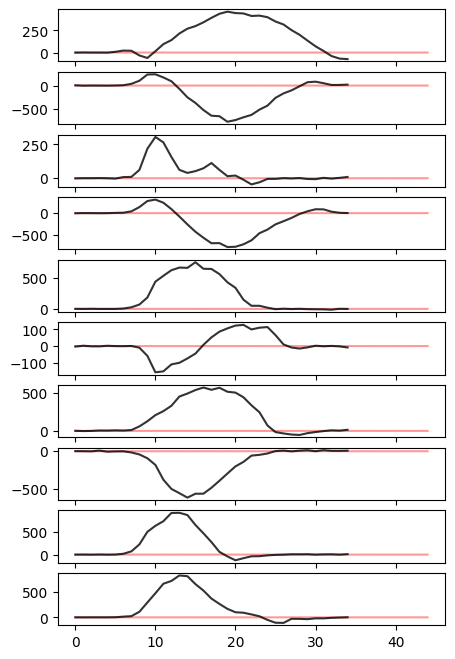

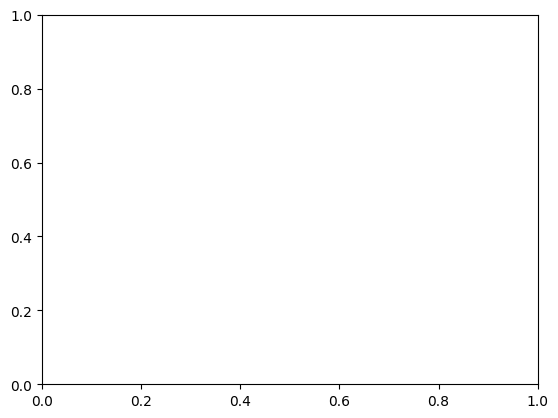

In [54]:
loss, z, stats = seq_vae.ssm(y_valid_obs, cfg.n_samples)

n_ex = 10

fig, axs = plt.subplots(n_ex, 1, figsize=(5, 8))

[axs[i].plot(stats['m_f'][i, :, 0].detach().numpy(), color='red', alpha=0.4) for i in range(n_ex)]
[axs[i].plot(vel_valid[i, :, 0].detach().numpy(), color='black', alpha=0.8) for i in range(n_ex)]

fig.show()

fig, axs = plt.subplots()
plot_utils.plot_two_d_vector_field(seq_vae.ssm.dynamics_mod.mean_fn, axs)
fig.show()